In [ ]:
#Resizing images
import os
import cv2

def resize_images_in_folder(input_folder, output_folder, target_size):
    #Create output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg'))]

    for image_file in image_files:
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)

        # Read the image
        image = cv2.imread(input_path)

        # Resize the image
        image_resized = cv2.resize(image, target_size)

        #Save resized image
        cv2.imwrite(output_path, image_resized)

#input_folder = './tumors/Training/pituitary_tumor/' #Input folder
#output_folder = './tumors/Training/pituitary_tumor_resized'  # My new folder containing resized images
#resize_images_in_folder(input_folder, output_folder, target_size=(512, 512))


In [45]:
import os #Interct with the operating system, create repo and files
import torch #ML
import torchvision #Pytorch package for computer vision
from torchvision.datasets.utils import download_url #Download from the internet
from torch.utils.data import random_split

In [46]:
data_dir = './tumors'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training/")
print(classes)

['Testing', 'Training']
['glioma_tumor_resized', 'meningioma_tumor_resized', 'no_tumor_resized', 'pituitary_tumor_resized']


In [47]:
glioma_tumor = os.listdir(data_dir + "/Training/glioma_tumor_resized")
len(glioma_tumor) #Number of training examples for glioma_tumor

826

In [48]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


In [49]:
transform = transforms.ToTensor()
dataset = ImageFolder(data_dir+'/Training', transform= transform)
print(len(dataset))

2870


In [50]:
dataset = torchvision.datasets.ImageFolder(root=data_dir + '/Training', transform=transform)
img, label = dataset[3]
print(img.shape, label)
img

torch.Size([3, 512, 512]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

The size of images is: ([3, 512, 512])

In [51]:
print(dataset.classes)
print(img.size())

['glioma_tumor_resized', 'meningioma_tumor_resized', 'no_tumor_resized', 'pituitary_tumor_resized']
torch.Size([3, 512, 512])


In [52]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'#Blanc

In [53]:
def show_example(img, label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0)) #(H, W, C)

Label:  glioma_tumor_resized (0)


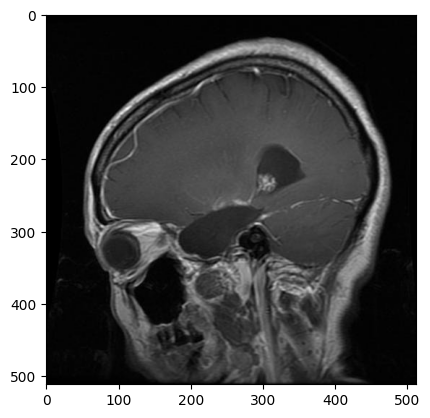

In [54]:
show_example(*dataset[3])

Label:  glioma_tumor_resized (0)


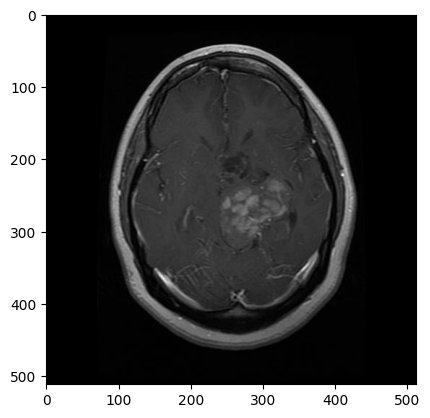

In [55]:
show_example(*dataset[0])

In [56]:
torch.manual_seed(42);

In [57]:
val_size = 1800
train_size = len(dataset) - val_size
print(train_size)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

1070


In [58]:
#Create dataloaders
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [59]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True)

In [60]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break


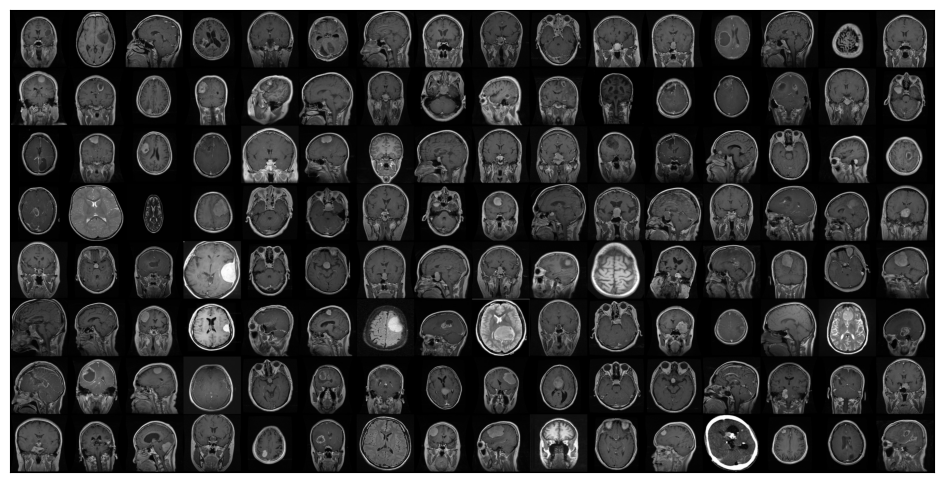

In [61]:
show_batch(train_dl)

In [62]:
import torch.nn as nn
import torch.nn.functional as F

In [63]:
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    images, labels = batch
    out = self(images) #Prediction
    loss = F.cross_entropy(out, labels) #Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images) #Prediction
    loss = F.cross_entropy(out, labels) #Calculate loss
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() #combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch[{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format,
          epoch, result['train_loss'], result['val_loss'], result['val_acc'])

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [66]:
class TumorCnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        #input: 3 x 512 x 512
        nn.Conv2d(3, 32, kernel_size = 3, padding=1),
        #output: 32 x 512 x 512
        nn.ReLU(),
        #input 32 x 512 x 512 
        nn.Conv2d(32, 64,kernel_size = 3, stride=1, padding=1),
        #output 64x32x32
        nn.ReLU(),
        nn.MaxPool2d(2,2), #Output 64 x 256 x 256

        nn.Conv2d(64, 128, kernel_size = 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128,kernel_size = 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #128 x 128 x 128

        #nn.Conv2d(128, 256, kernel_size = 3, padding=1),
        #nn.ReLU(),
        #nn.Conv2d(256, 256,kernel_size = 3, stride=1, padding=1),
        #nn.ReLU(),
        #nn.MaxPool2d(2,2), #Output 256x4x4

        nn.Flatten(),
        nn.Linear(256*4*4, 15),
        nn.ReLU(),
        nn.Linear(15, 10),
        nn.ReLU(),
        nn.Linear(10,4))


  def forward(self, xb):
      return self.network(xb)

In [67]:
model = TumorCnnModel()
model

TumorCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=4096, out_features=15, bias=True)
    (12): ReLU()
    (13): Linear(in_features=15, out_features=10, bias=True)
    (14): ReLU()
    (15): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [ ]:
for images, labels in train_dl[1:4]:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape', out.shape)
  print('out[0]', out[0])
  break